---
title: Análisis de Aceites
subtitle: Revisión de completitud
author: Chief Reliability
date: 2023-01-23
---

In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
from pathlib import Path


import pandas as pd
import polars as pl
import dagster as dg
from kdags.resources import *
from io import BytesIO
import pdfplumber
from datetime import datetime
import re
import os
from kdags.definitions import *
from kdags.readr import Readr
from kdags.resources.ggplot import *

import matplotlib.pyplot as plt
import numpy as np

context = dg.build_asset_context()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
oil_df = Readr.Maintenance.read_oil_analysis(context)

In [7]:
oil_analysis_categories = {
    "metals": [
        "al",  # ALUMINIO
        "cr",  # CROMO
        "cu",  # COBRE
        "fe",  # FIERRO
        "ni",  # NÍQUEL
        "pb",  # PLOMO
        "sn",  # ESTAÑO
    ],
    "contaminants": [
        "k",  # POTASIO
        "na",  # SODIO
        "si",  # SILICIO
    ],
    "additives": [
        "b",  # BORO
        "ca",  # CALCIO
        "mg",  # MAGNESIO
        "mo",  # MOLIBDENO
        "p",  # FÓSFORO
        "zn",  # ZINC
    ],
    "viscosity": [
        "viscosity_40c",  # VISCOSIDAD 40°C
        "viscosity_100c",  # VISCOSIDAD 100°C
    ],
    "physical_chemical": [
        "tbn",  # TBN
        "water",  # AGUA
        "fuel",  # DILUCIÓN
        "soot",  # ÍNDICE DE HOLLÍN
        "oxidation",  # OXIDACIÓN
        "sulfation",  # SULFATACIÓN
        "nitration",  # NITRACIÓN
        "tan",  # TAN (Número Ácido Total)
        "pq",  # PQ CONTAMINANTE
    ],
    "particles": [
        "particles_gt_4",  # Partículas >4 μm/mL
        "particles_gt_6",  # Partículas >6 μm/mL
        "particles_gt_14",  # Partículas >14 μm/mL
        # "iso_code",  # Código ISO
    ],
}
df = oil_df.clone().drop(["iso_code"]).rename({"sample_date": "record_date"})
idx_columns = [
    "sample_id",
    "equipment_name",
    "record_date",
    "received_date",
    "analysis_date",
    "pm_type",
    "equipment_hours",
    "component_code",
    "position_code",
    "is_microfiltered",
]
num_columns = [c for c in df.columns if c not in idx_columns]
df = (
    df.unpivot(
        index=idx_columns, variable_name="parameter_code", value_name="parameter_value"
    )
    .with_columns(
        parameter_category=pl.col("parameter_code").replace(
            {
                param: category
                for category, params in oil_analysis_categories.items()
                for param in params
            }
        ),
        parameter_value=pl.col("parameter_value").cast(pl.Float64, strict=False),
    )
    .filter(pl.col("is_microfiltered") == False)
    .filter(pl.col("parameter_category").is_in(list(oil_analysis_categories.keys())))
)
df

sample_id,equipment_name,record_date,received_date,analysis_date,pm_type,equipment_hours,component_code,position_code,is_microfiltered,parameter_code,parameter_value,parameter_category
str,str,date,date,date,str,str,str,i8,bool,str,f64,str
"""V35574""","""TK872""",2021-07-31,2021-07-31,2021-08-01,"""112D""","""59546""","""MT""",2,false,"""fe""",11.0,"""metals"""
"""V35573""","""TK872""",2021-07-31,2021-07-31,2021-08-01,"""112D""","""59546""","""MT""",1,false,"""fe""",7.0,"""metals"""
"""V35579""","""TK285""",2021-07-31,2021-07-31,2021-08-01,"""112D""","""3463""","""MT""",2,false,"""fe""",9.0,"""metals"""
"""V35578""","""TK285""",2021-07-31,2021-07-31,2021-08-01,"""112D""","""3463""","""MT""",1,false,"""fe""",9.0,"""metals"""
"""V35734""","""TK396""",2021-08-01,2021-08-01,2021-08-02,"""112D""","""52562""","""MT""",2,false,"""fe""",10.0,"""metals"""
…,…,…,…,…,…,…,…,…,…,…,…,…
"""800026394""","""TK286""",2025-03-17,2025-03-18,2025-03-18,"""28D""","""22564""","""MT""",2,false,"""particles_gt_14""",650.26,"""particles"""
"""800026393""","""TK286""",2025-03-17,2025-03-18,2025-03-18,"""28D""","""22564""","""MT""",1,false,"""particles_gt_14""",497.37,"""particles"""
"""800026397""","""TK879""",2025-03-17,2025-03-18,2025-03-18,null,null,"""MT""",2,false,"""particles_gt_14""",875.6,"""particles"""


(<Figure size 1200x700 with 1 Axes>,
 <Axes: title={'center': 'Propiedades Físico Químicas TK878 - Position 2'}, xlabel='Sample Date', ylabel='Parameter Value'>)

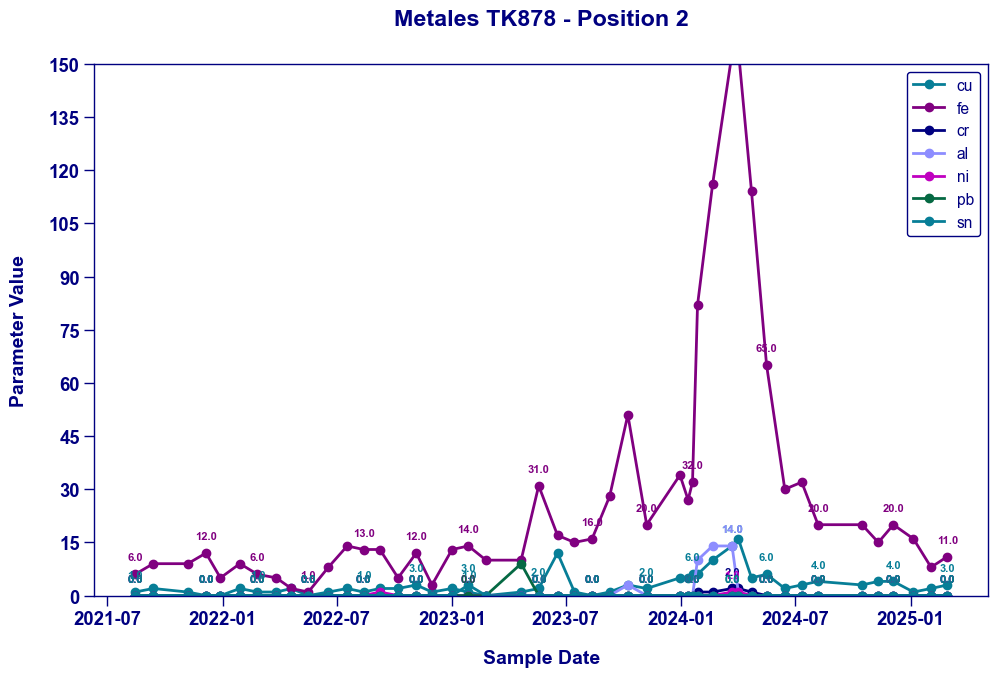

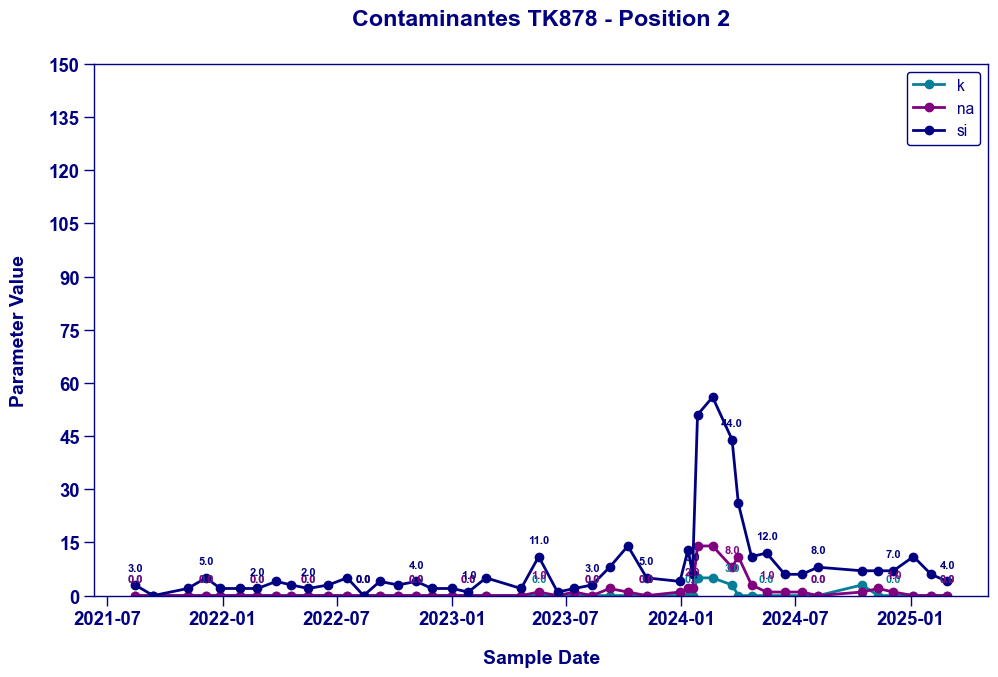

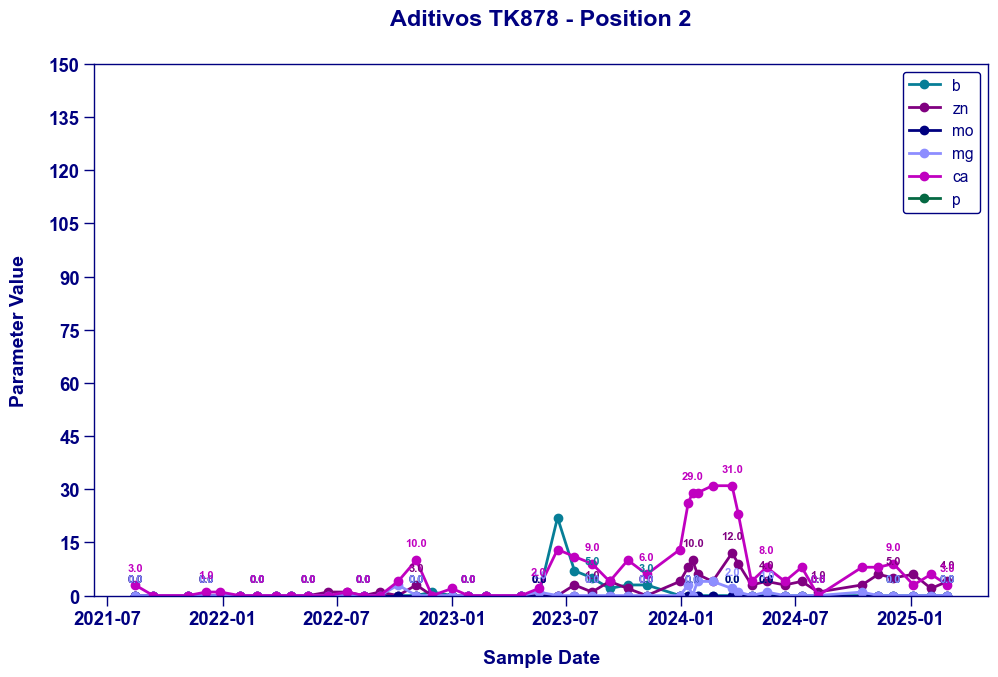

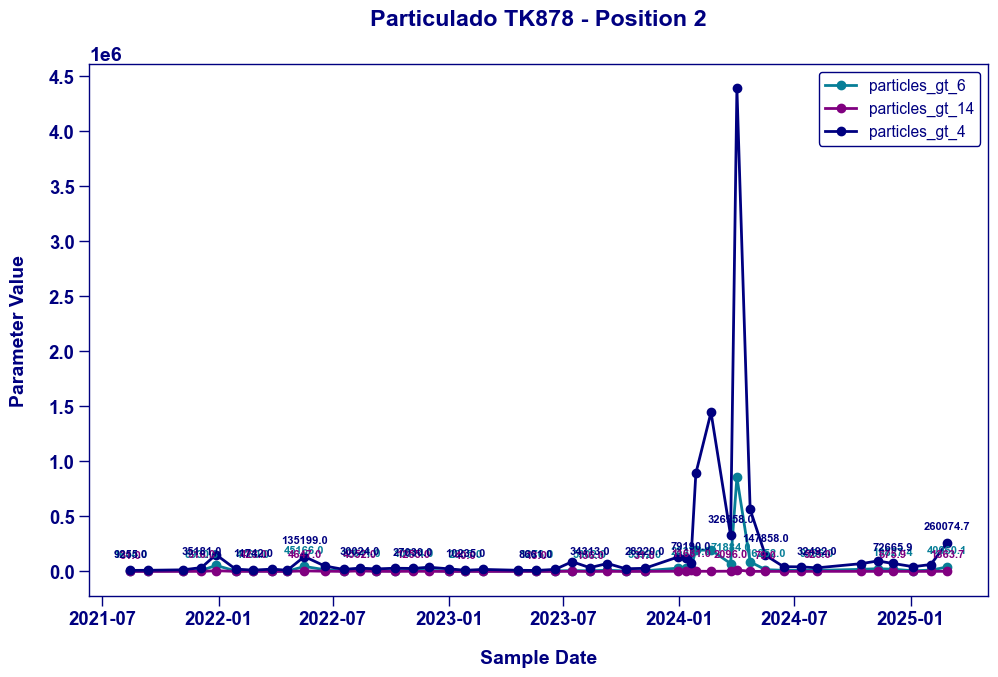

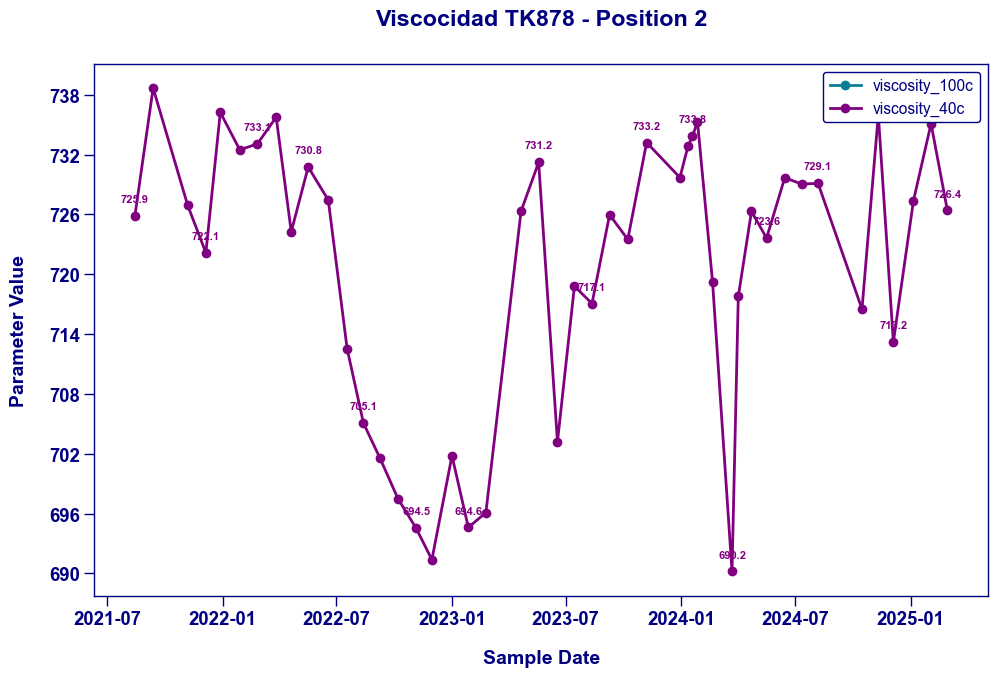

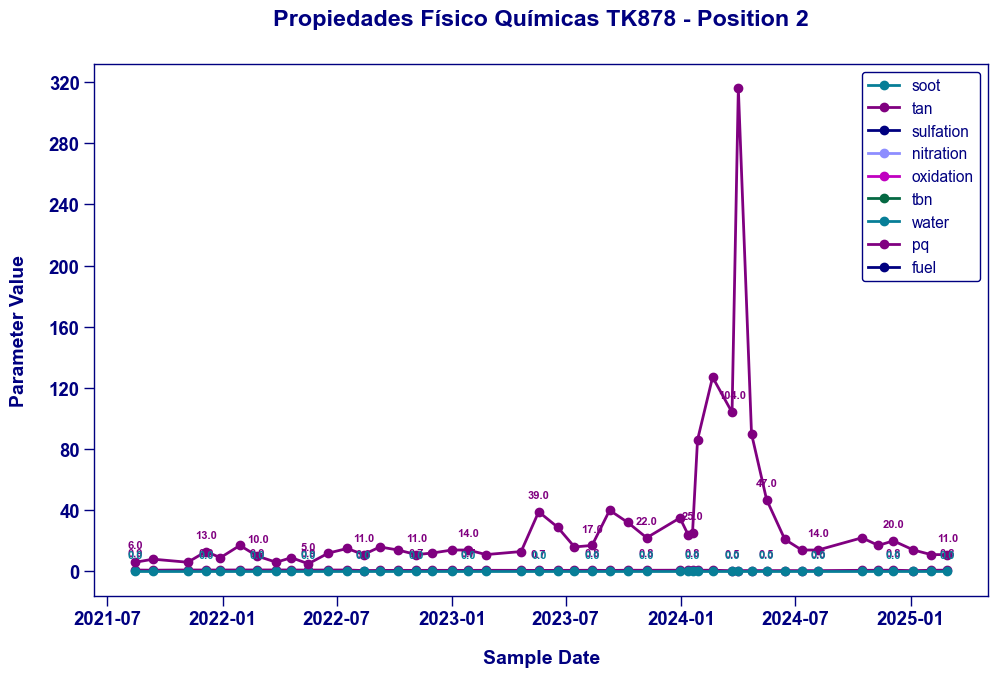

In [29]:
equipment_name = "TK878"
position_code = 2
ggplot_time_series(
    df,
    equipment_name=equipment_name,
    position_code=position_code,
    parameter_codes=df.filter(pl.col("parameter_category") == "metals")[
        "parameter_code"
    ].unique(),
    ylim=(0, 150),
    title=f"Metales {equipment_name} - Position {position_code}",
)

ggplot_time_series(
    df,
    equipment_name=equipment_name,
    position_code=position_code,
    parameter_codes=df.filter(pl.col("parameter_category") == "contaminants")[
        "parameter_code"
    ].unique(),
    ylim=(0, 150),
    title=f"Contaminantes {equipment_name} - Position {position_code}",
)

ggplot_time_series(
    df,
    equipment_name=equipment_name,
    position_code=position_code,
    parameter_codes=df.filter(pl.col("parameter_category") == "additives")[
        "parameter_code"
    ].unique(),
    ylim=(0, 150),
    title=f"Aditivos {equipment_name} - Position {position_code}",
)

ggplot_time_series(
    df,
    equipment_name=equipment_name,
    position_code=position_code,
    parameter_codes=df.filter(pl.col("parameter_category") == "particles")[
        "parameter_code"
    ].unique(),
    # ylim=(0, 150),
    title=f"Particulado {equipment_name} - Position {position_code}",
)

ggplot_time_series(
    df,
    equipment_name=equipment_name,
    position_code=position_code,
    parameter_codes=df.filter(pl.col("parameter_category") == "viscosity")[
        "parameter_code"
    ].unique(),
    # ylim=(0, 150),
    title=f"Viscocidad {equipment_name} - Position {position_code}",
)

ggplot_time_series(
    df,
    equipment_name=equipment_name,
    position_code=position_code,
    parameter_codes=df.filter(pl.col("parameter_category") == "physical_chemical")[
        "parameter_code"
    ].unique(),
    # ylim=(0, 150),
    title=f"Propiedades Físico Químicas {equipment_name} - Position {position_code}",
)